# Lab Part 4
# Neural Network Model Template

This file contains boilerplate for creating a neural network. Designing a neural network is quite difficult and requires a lot of time to set up data processing pipelines and image processing. As well as making sure that the tensors and datasets are in the correct formats. This file contains all that you need to make your very own neural network.

In [15]:
# Config Parameters for the model
# Set the batch size here
# increase for systems with more memory, 32 should be enough for most systems
BATCH_SIZE = 32

## Part 1: Unpack our data
All we do is install 7zip and then use pyunpack to extract the files. This saves datasets to /notebooks which is a directory on Paperspace Gradient that is acceptable by python.

In [16]:
# 本地环境数据加载
import zipfile
import os

# dataset file name
data_file = "data_0"  # 更改为您的数据集文件名

# 本地数据文件路径 - 修改为您的实际路径
local_zip_path = "/Users/xirongwang/hsubd-programing/machine-learning-practice-homework/data_0.zip"

# 检查文件是否存在
if os.path.exists(local_zip_path):
    print(f"找到数据文件: {local_zip_path}")
    
    # 解压文件
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall()
    
    data_dir = './' + data_file + '/'
    train_dir = data_dir + 'train/'
    test_dir = data_dir + 'test/'
    
    print(f"数据已解压到: {data_dir}")
else:
    print(f"错误: 找不到数据文件 {local_zip_path}")
    print("请确保数据文件存在或修改路径")
    
    # 如果没有数据文件，使用示例路径
    data_dir = './data_0/'
    train_dir = data_dir + 'train/'
    test_dir = data_dir + 'test/'

找到数据文件: /Users/xirongwang/hsubd-programing/machine-learning-practice-homework/data_0.zip
数据已解压到: ./data_0/


## Part 3: Loading in the data
### Dealing with images
Our image files that we are using for training are pretty large. Your computer may crash if we loaded them all at once so instead we will just store where the images are stored. Later you will see how we can automatically load these files when we run our code. One thing to note is that each image file is named (somenumber).jpg that number is the number of milliseconds since 1 January 1970 (Unix Time) when the file was recorded. This means that we will never have any overlapping files. Unfortunately this does mean we will have to sort the times from smallest to largest to make sure that they correspond with the steering angles which are recorded sequentially.

### Dealing with steering angles
We store our steering values as a csv (comma separated values) file. Python has a built in csv module so we can easily use it to load in all the steering values into a list. These don't take up much ram so it doesn't matter if we load them all in at once. They're just numbers after all.

### Making sure the files line up
Since we sort our images, and the csv file is read in line by line the files will line up with their correct steering angles. It looks something like this. If we mess this up then the data being fed into your network would be totally incoherent. Garbage in Garbage out.

train_img =   | image 1    | image 2    | image 3    | image 4    | image 5    |...

train_steer = | steering 1 | steering 2 | steering 3 | steering 4 | steering 5 |...

In [17]:
import csv
import os
# lets make a function that loads the images and labels
def load_data(directory):
    image__paths = []
    for file in os.listdir(directory): # for each file in the directory
        if file.endswith(".png"): # if the file is an image
            image__paths.append(directory + file) # add the image path to the list
    print(image__paths)
    # now our files are in the train list we need to sort them from smallest file name to largest. The file name is the exact time the image was taken.
    image__paths.sort(key=lambda x: int(x.split('/')[-1][:-4].split('_')[0][:])) # the lambda function returns the numbers in the file name
    print(image__paths)
    # now we get the steering angles
    steering_angles = [] # create a list to store the steering angles
    for angle in image__paths: # for each row in the csv file
        steering_angles.append(float(angle.split('/')[-1][:-4].split('_')[-1].replace('-','.'))) # add the steering angle to the list
    print(steering_angles)
    return image__paths, steering_angles # return the image paths and steering angles

# We call our load data function to get the image paths and steering angles
train_img, train_steer = load_data(train_dir) # load the training data
test_img, test_steer = load_data(test_dir) # load the test data





['./data_0/train/82_97-133.png', './data_0/train/65_102-558.png', './data_0/train/11_85-775.png', './data_0/train/30_111-081.png', './data_0/train/55_104-844.png', './data_0/train/22_91-072.png', './data_0/train/33_116-299.png', './data_0/train/68_101-592.png', './data_0/train/70_100-89.png', './data_0/train/46_108-626.png', './data_0/train/64_102-858.png', './data_0/train/35_117-175.png', './data_0/train/94_94-444.png', './data_0/train/52_105-522.png', './data_0/train/79_97-979.png', './data_0/train/66_102-263.png', './data_0/train/58_104-221.png', './data_0/train/25_96-245.png', './data_0/train/93_94-631.png', './data_0/train/75_99-213.png', './data_0/train/32_115-093.png', './data_0/train/16_89-041.png', './data_0/train/9_84-2.png', './data_0/train/27_102-15.png', './data_0/train/56_104-601.png', './data_0/train/15_88-5.png', './data_0/train/5_80-861.png', './data_0/train/49_106-664.png', './data_0/train/48_107-223.png', './data_0/train/45_109-382.png', './data_0/train/29_108-386.pn

## Part 4: Loading in the images

The below code is outside the scope of this course but a brief explanation is provided nevertheless.

### Dataset Creation
The dataset creation involves the creation of what is known as a dataset pipeline. All this is, is a sequence of transformations applied one after the other that manipulate the data in different ways.
1. from_tensor_slices. We load in the images and the steering angles into the dataset
2. repeat. Simply loop the dataset for infinity when we get to the end. This is done to make sure our network never runs out of data. For instance we train on batches of 32 if we had 52 images we would run out of data.
3. shuffle. Self explanatory makes sure we don't feed network ordered data as this can cause weird issues. Note we don't need to do this with our validation data so we might as well save the unnecessary operation by excluding shuffle.
4. batch. Tell the dataset that when we fetch a item from it is should return a number of items. This is more efficient as you almost certainly have enough RAM to handle more than 1 image.
5. Prefetch. Tell the dataset that when it's not doing anything it should automatically be loading data into RAM in the background. This results in huge performance increases as when we're training we don't have to sit around waiting for the dataset to load the images.




In [18]:
# 使用国内镜像源安装 OpenCV 和其他依赖
import subprocess
import sys

def install_packages_with_mirror():
    """使用国内镜像源安装所需的包"""
    
    # 国内镜像源配置
    mirrors = [
        "https://pypi.tuna.tsinghua.edu.cn/simple/",      # 清华大学镜像
        "https://pypi.douban.com/simple/",                # 豆瓣镜像
        "https://mirrors.aliyun.com/pypi/simple/",        # 阿里云镜像
        "https://pypi.mirrors.ustc.edu.cn/simple/"        # 中科大镜像
    ]
    
    # 选择镜像源（优先使用清华镜像）
    mirror = mirrors[0]
    
    # 需要安装的包
    packages = [
        "opencv-python",
        "tqdm", 
        "matplotlib",
        "tensorflow",
        "numpy"
    ]
    
    print(f"🔧 使用镜像源: {mirror}")
    
    for package in packages:
        try:
            # 先检查是否已安装
            __import__(package.replace('-', '_') if package == 'opencv-python' else package.split('==')[0])
            print(f"✅ {package} 已安装")
        except ImportError:
            print(f"📦 正在安装 {package}...")
            try:
                # 使用镜像源安装
                cmd = [
                    sys.executable, "-m", "pip", "install", 
                    "-i", mirror,
                    "--trusted-host", mirror.split("://")[1].split("/")[0],
                    package
                ]
                subprocess.check_call(cmd)
                print(f"✅ {package} 安装成功")
            except Exception as e:
                print(f"❌ {package} 安装失败: {e}")
                # 尝试下一个镜像源
                if mirror != mirrors[-1]:
                    next_mirror = mirrors[mirrors.index(mirror) + 1]
                    print(f"🔄 尝试备用镜像源: {next_mirror}")
                    try:
                        cmd[5] = next_mirror
                        cmd[7] = next_mirror.split("://")[1].split("/")[0]
                        subprocess.check_call(cmd)
                        print(f"✅ {package} 使用备用镜像安装成功")
                    except Exception as e2:
                        print(f"❌ 备用镜像也失败: {e2}")

# 运行安装
install_packages_with_mirror()

# 导入 OpenCV
try:
    import cv2 as cv
    print("🎉 OpenCV 已准备就绪！")
except ImportError:
    print("❌ OpenCV 导入失败，请检查安装")

🔧 使用镜像源: https://pypi.tuna.tsinghua.edu.cn/simple/
📦 正在安装 opencv-python...
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
✅ opencv-python 安装成功
✅ tqdm 已安装
✅ matplotlib 已安装
✅ tensorflow 已安装
✅ numpy 已安装
🎉 OpenCV 已准备就绪！


Loading training data


100%|██████████| 100/100 [00:00<00:00, 4213.43it/s]


Loading test data


100%|██████████| 50/50 [00:00<00:00, 7374.73it/s]
/var/folders/8f/s8cd84vs6ln67ggwr23649m80000gn/T/ipykernel_54839/3903948448.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


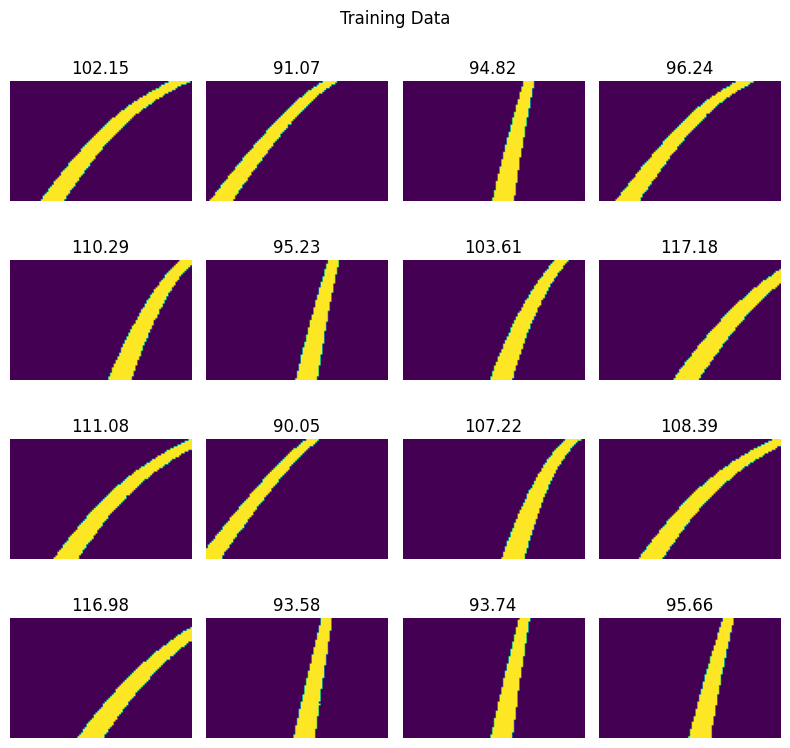

In [19]:
import matplotlib.pyplot as plt # import matplotlib for plotting
import tensorflow as tf
import cv2 as cv
#from google.colab.patches import cv2_imshow
import numpy as np
import tqdm

train_data = []
test_data = []

tqdm.tqdm.write("Loading training data")
# load the images and steering angles into numpy arrays
for path in tqdm.tqdm(train_img):
    img = cv.imread(path) # read the image
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # mask the image to get only the desired colors
    mask = cv.inRange(hsv, (36, 0, 0), (70, 255,255))
    array = np.array(mask, dtype=np.float32)
    train_data.append(array)

tqdm.tqdm.write("Loading test data")
# loading the testing data
for path in tqdm.tqdm(test_img):
    img = cv.imread(path) # read the image
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # mask the image to get only the desired colors
    mask = cv.inRange(hsv, (36, 0, 0), (70, 255,255))
    array = np.array(mask, dtype=np.float32)
    test_data.append(array)

# create a dataset from the training data and make a data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_steer)) # create a dataset from the image paths and steering angles
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(buffer_size=len(train_img)) # shuffle the dataset
train_ds = train_ds.batch(BATCH_SIZE) # batch the dataset
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch the dataset to improve performance

# create a dataset from the testing data and make a data pipeline
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_steer)) # create a dataset from the image paths and steering angles
test_ds = test_ds.repeat() # repeat the dataset
test_ds = test_ds.batch(BATCH_SIZE) # batch the dataset
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch the dataset to improve performance

# output the first 16 images and steering angles from the dataset
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
# add title to the figure
fig.suptitle('Training Data')
fig.tight_layout()

imgs, steer = next(iter(train_ds)) # get the first batch of images and steering angles

for i in range(16):
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].imshow(imgs[i])
    axs[i//4, i%4].set_title(round(steer[i].numpy(), 2))
plt.tight_layout()
plt.show()

## Part 5: This is where you will create your model
try modifying the layers to try to get the lowest mse score,
This is going to require some trial and error so make sure you spend some time experimenting.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (32, 64, 98, 96)          960       
                                                                 
 max_pooling2d_2 (MaxPoolin  (32, 21, 32, 96)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (32, 19, 30, 48)          41520     
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 6, 10, 48)           0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (32, 2880)                0         
                                                                 
 dense_8 (Dense)             (32, 64)                 

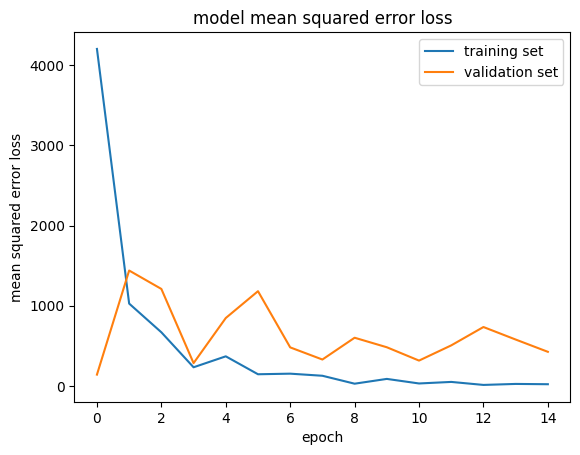

In [20]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Conv2D, Flatten, MaxPool2D, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# a sequential model is a model that is made up of layers
model = Sequential()
# the input layer is the first layer in the model. You shouldn't need to change this.
model.add(InputLayer(input_shape=(66, 100, 1), batch_size=BATCH_SIZE))

# try modifying the number of nodes in the hidden layer to see how it affects the model
# you can also try changing the activation function to see how it affects the model
# adding more layers to the model may also

# in this lab you also have access to the Conv2D layer and MaxPool2D layer. Try modifying these to see how they affect the model.
model.add(Conv2D(96, (3, 3), activation='relu'))  # conv layer -1 96 filters size 3x3
model.add(MaxPool2D(pool_size=(3, 3)))  # pooling layer size 3x3
model.add(Conv2D(48, (3, 3), activation='relu'))  # conv layer-2 with 48 filters size 3x3
model.add(MaxPool2D(pool_size=(3, 3)))  # pooling layer size

model.add(Flatten())  # flatten layer
model.add(Dense(64, activation='relu'))  # hidden dense layer with 64 units
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.001)  # try changing the learning rate to see how it affects the model
model.compile(optimizer=optimizer, loss='mse')  # we will keep track of the mean squared error

print(model.summary())  # print a summary of the model

# Train the model without EarlyStopping
epoch = 15
hist = model.fit(train_ds,
                 steps_per_epoch=len(train_img) // BATCH_SIZE,
                 validation_data=test_ds,
                 validation_steps=len(test_img) // BATCH_SIZE,
                 epochs=epoch)  # EarlyStopping removed

# let's plot the model's history
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
# plt.plot(np.log(hist.history['loss']))       # log scale
# plt.plot(np.log(hist.history['val_loss']))   # log scale
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


Have a look at the graph generated below. With this you can get an idea of whether your model is training well. You should want to see both lines trend downwards.

## Part 6: Test the model
We'll now output 16 images with the predicted steering angles along with the actual steering angles

/var/folders/8f/s8cd84vs6ln67ggwr23649m80000gn/T/ipykernel_54839/2694518123.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


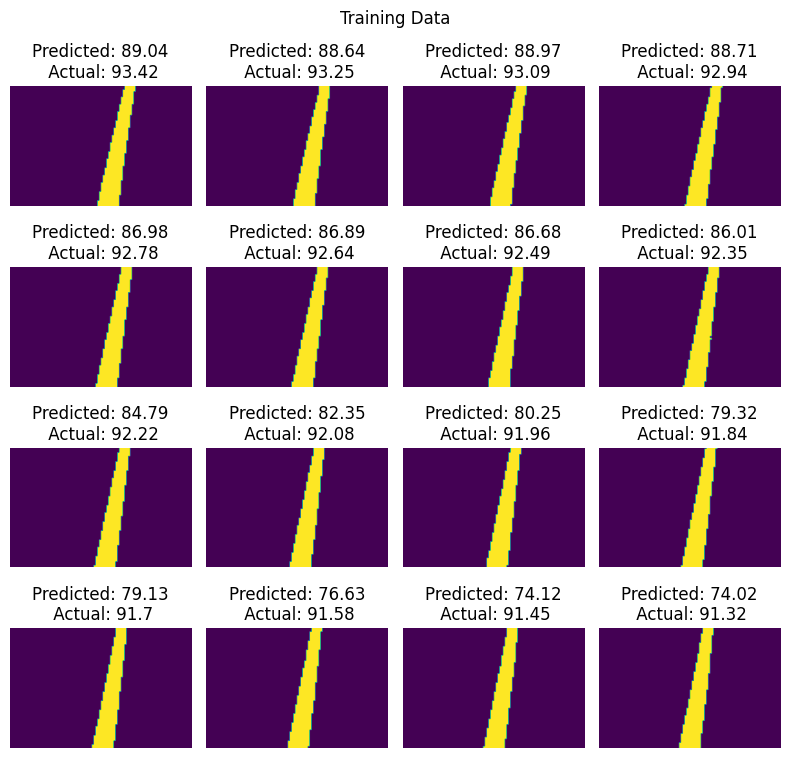

In [21]:
# output the first 16 images and steering angles from the test dataset then predict the steering angle for the images
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
# add title to the figure
fig.suptitle('Training Data')
fig.tight_layout()

imgs, steer = next(iter(test_ds)) # get the first batch of images and steering angles

for i in range(16):
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].imshow(imgs[i])
    axs[i//4, i%4].set_title(round(steer[i].numpy(), 2))
    predicted = model(imgs[i].numpy().reshape(1, 66, 100, 1)) # predict the steering angle for the image
    axs[i//4, i%4].set_title("Predicted: " + str(np.round(predicted[0][0].numpy(), 2)) + "\n Actual: " + str(round(steer[i].numpy(), 2)))
plt.tight_layout()
plt.show()

## Part 7: export your model
Once you are happy with your model you can export it by running the code below.
This will save your model as model.h5 and model.onnx.

The ".h5" model is used for the physical PiCar and the ".onnx" model is used for the PiCar Simulator. You can change this to be more descriptive. I also recommend saving multiple models with different training settings so you have a couple to experiment with.

In [23]:
# 使用国内镜像源安装 ONNX 相关包
import subprocess
import sys

def install_onnx_packages():
    """使用镜像源安装 ONNX 包"""
    
    mirror = "https://pypi.tuna.tsinghua.edu.cn/simple/"
    host = "pypi.tuna.tsinghua.edu.cn"
    
    packages = ["onnx", "tf2onnx"]
    
    for package in packages:
        try:
            __import__(package.replace('-', '_'))
            print(f"✅ {package} 已安装")
        except ImportError:
            print(f"📦 正在安装 {package}...")
            try:
                cmd = [
                    sys.executable, "-m", "pip", "install",
                    "-i", mirror,
                    "--trusted-host", host,
                    package
                ]
                subprocess.check_call(cmd)
                print(f"✅ {package} 安装成功")
            except Exception as e:
                print(f"❌ {package} 安装失败: {e}")

install_onnx_packages()

✅ onnx 已安装
✅ tf2onnx 已安装


In [24]:
import onnx
import tf2onnx
import tensorflow as tf

model_name = "model" # change the name to something more descriptive if you want
model.save(model_name + '.keras')
model.save(model_name + ".h5")
model.output_names = ['output']
input_signature = [tf.TensorSpec([None, 66, 100, 1], tf.float32, name='input')]

onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)

onnx.save(onnx_model, model_name + ".onnx")

/opt/miniconda3/envs/environment3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
